# MLP-VAE on minst dataset
 

Source: https://arxiv.org/pdf/1312.6114.pdf <br>
Tuto: https://keras.io/examples/variational_autoencoder/

 ## Data Loading

In [1]:
from tensorflow.keras.datasets import mnist
(xtr,ytr),(xtest,ytest) = mnist.load_data()

xtr = xtr.astype('float32')/255
xtest = xtest.astype('float32')/255

lengthMinstData = xtr.shape[1]*xtr.shape[2]

# Reshape x
xtr = xtr.reshape((-1, lengthMinstData ))
xtest = xtest.reshape((-1, lengthMinstData  ))


## Model Creation

In [2]:
import os
from tensorflow.keras.layers import Dense, Lambda, Input
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from PIL import Image
from tensorflow.keras.losses import mse, binary_crossentropy
import numpy as np

In [3]:
# Model parametres
latentSize = 2
denseSize = 512
epoch = 50

### Encoder

In [4]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]# number of records
    dim = K.int_shape(z_mean)[1] # shape of the matrix
    epsilon = K.random_normal( shape=(batch,dim) )
    
    return z_mean + K.exp( 0.5 * z_log_var ) * epsilon
    

In [5]:
inputs = Input(shape=xtr[0].shape,name='encode_input')

x = Dense(denseSize,activation='relu')(inputs)


z_mean =  Dense(latentSize ,name='z_mean')(x)
z_log_var =  Dense(latentSize,name='z_log_var')(x)

z = Lambda(function=sampling,output_shape=(latentSize,),name='z')([z_mean,z_log_var])


encoder = Model(inputs,[z_mean,z_log_var,z],name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encode_input (InputLayer)       [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          401920      encode_input[0][0]               
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense[0][0]                      
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense[0][0]                      
____________________________________________________________________________________________

### Decoder

In [6]:
latent_inputs = Input(shape=(latentSize,), name="z_sampling")

x = Dense(denseSize,activation='relu')(latent_inputs)

outputs = Dense(lengthMinstData,activation='sigmoid')(x)

decoder = Model(latent_inputs,outputs,name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_2 (Dense)              (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


### VAE

In [7]:
outputs = decoder( encoder(inputs)[2] )
vae = Model(inputs,outputs,name='VAE_MLP')
vae.summary()

Model: "VAE_MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encode_input (InputLayer)    [(None, 784)]             0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


## Loss

The loss of the vae is the sum of 2 losses function:
- Reconstruction loss: This loss is a measure of the difference between the input and the output of the vae model.
- Kullback–Leibler divergence: 

### Reconstruction Loss

2 reconstruction losses are possible:
- mse
- binary_crossentropy

In [8]:
reconstruction_mse = mse( inputs,outputs)

In [9]:
reconstruction_crossEntropy = binary_crossentropy( inputs,outputs)

### Kl loss

In [10]:
kl_loss = -K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var),axis=-1)/2

### Global loss

In [11]:
vae_loss = K.mean( kl_loss + reconstruction_crossEntropy*lengthMinstData)

## Training

In [12]:
#Compile vae model
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [13]:
vae.fit(x=xtr,epochs=epoch,batch_size=512,validation_data=[xtest,None])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 35us/sample - loss: 244.4221 - val_loss: 192.3033
Epoch 2/50
60000/60000 [==============================] - 1s 18us/sample - loss: 187.4827 - val_loss: 181.7354
Epoch 3/50
60000/60000 [==============================] - 1s 19us/sample - loss: 178.6891 - val_loss: 174.4878
Epoch 4/50
60000/60000 [==============================] - 1s 19us/sample - loss: 172.9453 - val_loss: 170.4417
Epoch 5/50
60000/60000 [==============================] - 1s 19us/sample - loss: 169.0290 - val_loss: 167.2849
Epoch 6/50
60000/60000 [==============================] - 1s 18us/sample - loss: 166.4309 - val_loss: 165.7093
Epoch 7/50
60000/60000 [==============================] - 1s 19us/sample - loss: 164.7023 - val_loss: 163.9522
Epoch 8/50
60000/60000 [==============================] - 1s 19us/sample - loss: 163.3944 - val_loss: 163.0143
Epoch 9/50
60000/60000 [==============================] - 1s 1

### Vizualisation

In [14]:
from matplotlib import pyplot as plt
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    # display a 2D plot of the digit classes in the latent space
    z_mean,_,_ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

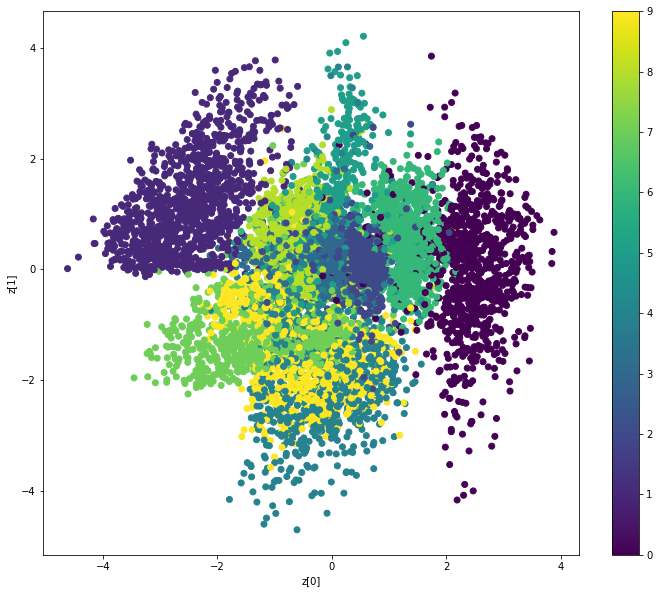

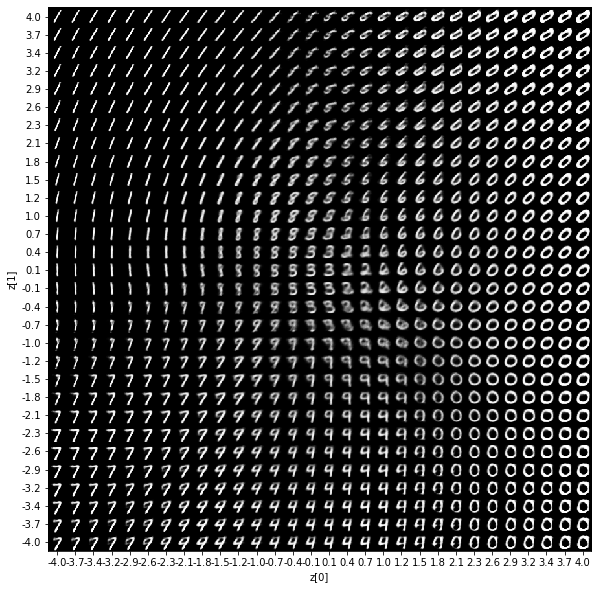

In [15]:
plot_results((encoder,decoder),(xtest,ytest),model_name="vae_mlp")